In [ ]:
import pandas as pd
import numpy as np
# Read individual files
df_icmp = pd.read_csv('/content/drive/MyDrive/Capstone/TCP_IP-DDoS-ICMP1_train.pcap.csv')
df_tcp  = pd.read_csv('/content/drive/MyDrive/Capstone/TCP_IP-DDoS-TCP1_train.pcap.csv')
df_syn  = pd.read_csv('/content/drive/MyDrive/Capstone/TCP_IP-DDoS-SYN1_train.pcap.csv')
df_udp  = pd.read_csv('/content/drive/MyDrive/Capstone/TCP_IP-DDoS-UDP1_train.pcap.csv')
df_benign = pd.read_csv('/content/drive/MyDrive/Capstone/Benign_train.pcap.csv')


In [ ]:
df_icmp['Label'] = 'ICMP'
df_tcp['Label']  = 'TCP'
df_syn['Label']  = 'SYN'
df_udp['Label']  = 'UDP'
df_benign['Label'] = 'Benign'

In [ ]:
# --- Step 3: Define a Common Cleaning Function ---
def clean_df(df, numeric_cols, label):
    # Standardize column names: remove extra spaces and convert to lower case.
    df.columns = df.columns.str.strip().str.lower()

    # Convert specified columns to numeric, replacing non-numeric values with NaN.
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Replace inf/-inf values with NaN.
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Impute missing values in numeric columns with the median.
    for col in numeric_cols:
        if col in df.columns and df[col].isna().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    # Remove duplicate rows.
    df.drop_duplicates(inplace=True)

    # Ensure the Label column is set correctly.
    df['label'] = label
    return df

# List of numeric columns to convert and clean.
# Adjust this list according to the features in your dataset.
numeric_cols = ['duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number',
                'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
                'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
                'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp',
                'dhcp', 'arp', 'icmp', 'igmp', 'ipv', 'llc', 'tot sum', 'min', 'max',
                'avg', 'std', 'tot size', 'iat', 'number', 'magnitude', 'radius',
                'covariance', 'variance', 'weight']


In [ ]:
# --- Step 4: Apply the Cleaning Function to All DataFrames at Once ---
# Store each DataFrame in a dictionary with its corresponding label.
dfs = {
    'ICMP': df_icmp,
    'TCP': df_tcp,
    'SYN': df_syn,
    'UDP': df_udp,
    'Benign': df_benign
}

# Apply our cleaning function to each DataFrame.
cleaned_dfs = {label: clean_df(df.copy(), numeric_cols, label) for label, df in dfs.items()}

# --- Optional: Verify Each Cleaned DataFrame ---
for label, df in cleaned_dfs.items():
    print(f"Cleaned DataFrame for {label} - shape: {df.shape}")
    print(df.info(), "\n")

Cleaned DataFrame for ICMP - shape: (194938, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194938 entries, 0 to 194937
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   header_length    194938 non-null  float64
 1   protocol type    194938 non-null  float64
 2   duration         194938 non-null  float64
 3   rate             194938 non-null  float64
 4   srate            194938 non-null  float64
 5   drate            194938 non-null  float64
 6   fin_flag_number  194938 non-null  float64
 7   syn_flag_number  194938 non-null  float64
 8   rst_flag_number  194938 non-null  float64
 9   psh_flag_number  194938 non-null  float64
 10  ack_flag_number  194938 non-null  float64
 11  ece_flag_number  194938 non-null  float64
 12  cwr_flag_number  194938 non-null  float64
 13  ack_count        194938 non-null  float64
 14  syn_count        194938 non-null  float64
 15  fin_count        194938 non-null  fl

In [ ]:
# --- Step 5: Merge the Cleaned DataFrames ---
merged_df = pd.concat(cleaned_dfs.values(), ignore_index=True)
print(f"Merged DataFrame shape: {merged_df.shape}")

# Optionally, save the merged DataFrame for further processing.
merged_df.to_csv('/content/drive/MyDrive/Capstone/CICIoMT2024_cleaned_merged.csv', index=False)

Merged DataFrame shape: (995541, 46)


KeyboardInterrupt: 

In [ ]:
print(merged_df['label'].value_counts())


label
UDP       206170
TCP       202311
SYN       199390
ICMP      194938
Benign    192732
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_df['label_encoded'] = label_encoder.fit_transform(merged_df['label'])


In [ ]:
from sklearn.preprocessing import StandardScaler

# Exclude non-numerical columns
features = merged_df.drop(columns=['label', 'label_encoded'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add the encoded label back
df_scaled['label_encoded'] = merged_df['label_encoded']


In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # Adjust threshold if needed
selector.fit(df_scaled.drop(columns=['label_encoded']))

low_variance_cols = df_scaled.drop(columns=['label_encoded']).columns[~selector.get_support()]
print("Low variance columns:", low_variance_cols.tolist())


Low variance columns: ['drate']


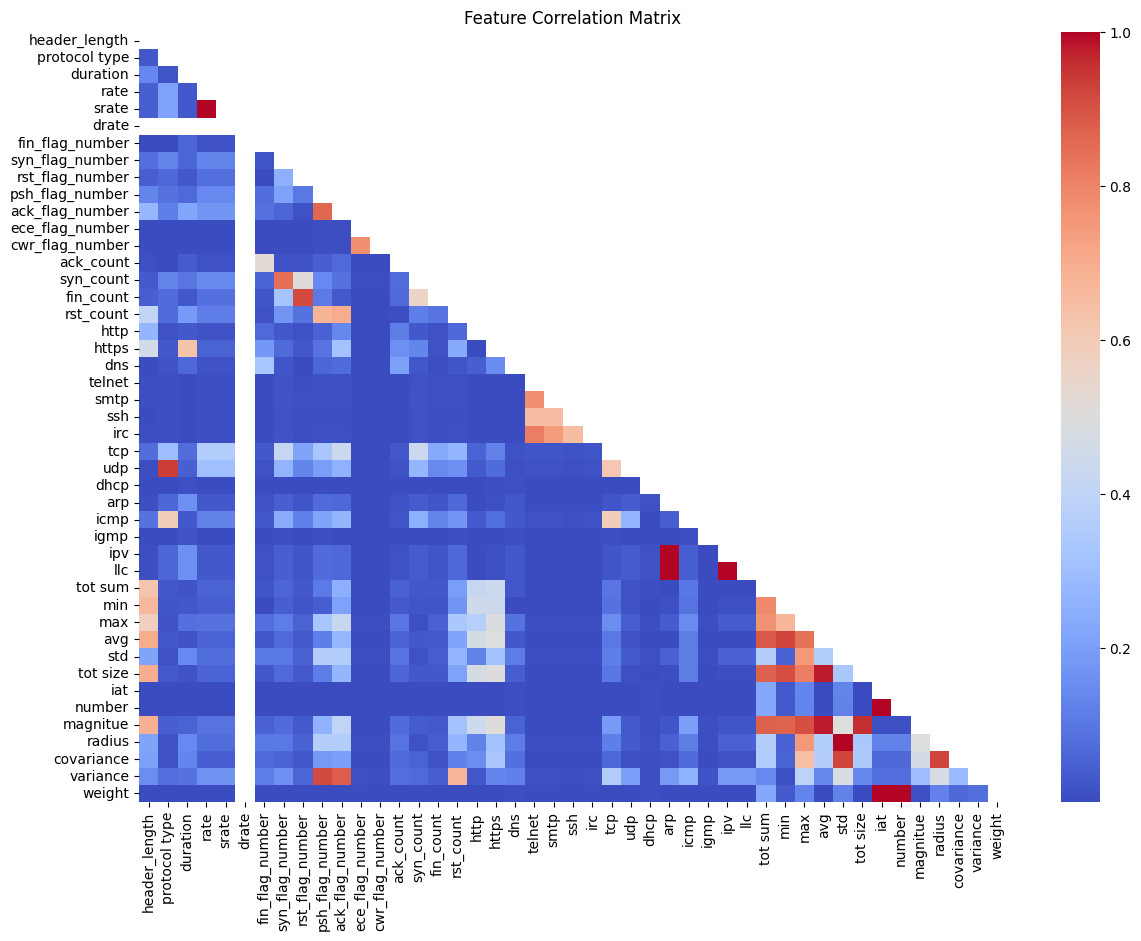

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_scaled.drop(columns=['label_encoded']).corr().abs()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
to_drop = [
    'drate',         # Low variance
    'srate',         # High corr with rate
    'ipv', 'llc',    # High corr with arp
    'tot size', 'magnitue',  # High corr with avg
    'radius',        # High corr with std
    'number', 'weight'  # High corr with iat
]
df_cleaned = df_scaled.drop(columns=to_drop)


In [ ]:
# Final training data
X_train = df_scaled.drop(columns=['label_encoded'])
y_train = df_scaled['label_encoded']


## RL-Based Feature Selection

In [ ]:
# RL-based Feature Selection Agent
class FeatureSelectionAgent:
    """
    Reinforcement Learning agent for feature selection as described in the paper
    """
    def __init__(self, feature_space, max_features=23):
        self.feature_space = feature_space  # All available features
        self.max_features = max_features    # Target number of features (23 as per paper)
        self.state_size = len(feature_space)
        self.action_size = len(feature_space)

        # Initialize Q-table: rows are states (represented by selected features)
        # and columns are actions (add/remove feature)
        self.q_table = {}

        # Learning parameters
        self.alpha = 0.1      # Learning rate
        self.gamma = 0.95     # Discount factor
        self.epsilon = 1.0    # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        # Keep track of selected features
        self.selected_features = []

    def get_state_key(self, selected_features):
        """Convert selected features list to a hashable state key"""
        return tuple(sorted(selected_features))

    def get_q_value(self, state_key, action):
        """Get Q-value for a state-action pair"""
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        return self.q_table[state_key][action]

    def select_action(self, selected_features):
        """
        Select an action (add/remove feature) using epsilon-greedy policy
        """
        state_key = self.get_state_key(selected_features)

        # Initialize Q-values for this state if not exists
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)

        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            # Exploration: randomly select feature to add/remove
            valid_actions = []
            for i in range(self.action_size):
                # Can add feature if not already selected and we haven't reached max features
                if i not in selected_features and len(selected_features) < self.max_features:
                    valid_actions.append(i)
                # Can remove feature if already selected
                elif i in selected_features:
                    valid_actions.append(i)

            if valid_actions:
                return np.random.choice(valid_actions)
            else:
                return None  # No valid actions
        else:
            # Exploitation: select best action
            valid_actions = []
            valid_q_values = []

            for i in range(self.action_size):
                # Can add feature if not already selected and we haven't reached max features
                if i not in selected_features and len(selected_features) < self.max_features:
                    valid_actions.append(i)
                    valid_q_values.append(self.q_table[state_key][i])
                # Can remove feature if already selected
                elif i in selected_features:
                    valid_actions.append(i)
                    valid_q_values.append(self.q_table[state_key][i])

            if valid_actions:
                return valid_actions[np.argmax(valid_q_values)]
            else:
                return None  # No valid actions

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-learning update rule"""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        # Initialize Q-values for next state if not exists
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_size)

        # Q-learning update
        best_next_q = np.max(self.q_table[next_state_key])
        current_q = self.q_table[state_key][action]

        # Q(s,a) = Q(s,a) + alpha * [reward + gamma * max_a' Q(s',a') - Q(s,a)]
        self.q_table[state_key][action] = current_q + self.alpha * (reward + self.gamma * best_next_q - current_q)

    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def select_features(self, X, y, n_episodes=100, test_size=0.3):
        """
        Use reinforcement learning to select the optimal feature subset
        Args:
            X: Feature matrix
            y: Target labels
            n_episodes: Number of RL episodes
            test_size: Test set proportion
        Returns:
            List of selected feature indices
        """
        print("Starting RL-based feature selection...")
        best_feature_set = []
        best_score = 0

        # Create a basic classifier for evaluation
        clf = RandomForestClassifier(n_estimators=50, random_state=42)

        for episode in range(n_episodes):
            # Start with an empty feature set
            current_features = []

            # Take up to max_features steps
            for step in range(self.max_features * 2):  # Allow add/remove operations
                action = self.select_action(current_features)

                if action is None:
                    break  # No valid actions left

                # Take action: add or remove feature
                old_features = current_features.copy()

                if action in current_features:
                    current_features.remove(action)  # Remove feature
                else:
                    current_features.append(action)  # Add feature

                # Evaluate the new feature set
                if len(current_features) > 0:
                    # Select subset of features
                    X_subset = X[:, current_features]

                    # Split data
                    X_train, X_test, y_train, y_test = train_test_split(
                        X_subset, y, test_size=test_size, random_state=42
                    )

                    # Train and evaluate classifier
                    try:
                        clf.fit(X_train, y_train)
                        accuracy = clf.score(X_test, y_test)

                        # Calculate additional metrics for reward
                        y_pred = clf.predict(X_test)
                        precision = precision_score(y_test, y_pred, average='weighted')
                        recall = recall_score(y_test, y_pred, average='weighted')
                        f1 = f1_score(y_test, y_pred, average='weighted')

                        # Calculate computational efficiency metrics
                        start_time = time.time()
                        clf.predict(X_test)
                        prediction_time = time.time() - start_time

                        # Reward function balancing accuracy with efficiency (as per paper)
                        feature_ratio = len(current_features) / self.max_features
                        reward = (0.6 * accuracy + 0.2 * f1 + 0.2 * (1.0 - prediction_time / 0.1)) * (1.0 - 0.3 * feature_ratio)

                        # Update Q-values
                        self.update_q_value(old_features, action, reward, current_features)

                        # Track best feature set
                        if accuracy > best_score and len(current_features) <= self.max_features:
                            best_score = accuracy
                            best_feature_set = current_features.copy()

                            print(f"Episode {episode+1}/{n_episodes}, New best feature set found:")
                            print(f"  Features: {len(best_feature_set)}/{self.max_features}")
                            print(f"  Accuracy: {best_score:.4f}, F1: {f1:.4f}")

                    except Exception as e:
                        # Handle case where feature set is invalid (e.g., all features are constant)
                        reward = -1.0
                        self.update_q_value(old_features, action, reward, current_features)
                else:
                    # Empty feature set gets negative reward
                    reward = -1.0
                    self.update_q_value(old_features, action, reward, current_features)

            # Decay exploration rate
            self.decay_epsilon()

            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{n_episodes}, Epsilon: {self.epsilon:.4f}")

        print("Feature selection completed.")
        print(f"Selected {len(best_feature_set)}/{self.max_features} features with accuracy: {best_score:.4f}")

        return best_feature_set

## Dataset Partitioning

In [ ]:
def partition_dataset(df, num_partitions=3):
    partitions = []
    partition_size = len(df) // num_partitions

    for i in range(num_partitions):
        start_idx = i * partition_size
        if i == num_partitions - 1:
            end_idx = len(df)  # Last partition takes remaining data
        else:
            end_idx = (i + 1) * partition_size

        partitions.append(df.iloc[start_idx:end_idx].copy())

    return partitions


## Federated Learning Training

In [ ]:
# Global test data split for final evaluation
from sklearn.model_selection import train_test_split

X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)
print("\nStarting Federated Learning Training Process...")

dataset_sizes = [len(p[0]) for p in partition_data]
history = {'global_accuracy': [], 'local_accuracies': [[] for _ in agents]}

for epoch in range(num_epochs):
    print(f"\n--- Federated Round {epoch+1}/{num_epochs} ---")
    local_weights = []

    for i, agent in enumerate(agents):
        print(f"Training local agent {i+1}...")

        X_local, y_local = partition_data[i]
        agent.model.set_weights(fed_server.global_model.get_weights())

        # Local training
        for _ in range(num_local_epochs):
            indices = np.random.permutation(len(X_local))
            for j in indices:
                state = X_local[j]
                label = int(y_local[j])
                action = agent.act(state)
                reward = 10 if action == label else -10
                next_state = state
                done = True
                agent.remember(state, action, reward, next_state, done)
                agent.replay()

        # Evaluate
        predictions = [agent.act(x, training=False) for x in X_local]
        accuracy = accuracy_score(y_local, predictions)
        history['local_accuracies'][i].append(accuracy)
        print(f"Local accuracy agent {i+1}: {accuracy:.4f}")

        local_weights.append(agent.model.get_weights())

    # Aggregate on server
    global_weights = fed_server.aggregate_models(local_weights, dataset_sizes)
    fed_server.global_model.set_weights(global_weights)

    # Global evaluation
    y_pred = [np.argmax(fed_server.global_model.predict(x.reshape(1, -1), verbose=0)) for x in X_test_global]
    global_acc = accuracy_score(y_test_global, y_pred)
    history['global_accuracy'].append(global_acc)

    print(f"Global Accuracy after Round {epoch+1}: {global_acc:.4f}")


## Final Evaluation Block

In [ ]:
def final_evaluation(fed_server, X_test_global, y_test_global, state_size):
    print("\n--- Final Evaluation ---")

    y_pred, detection_times = [], []

    for x in X_test_global:
        x_reshaped = x.reshape(1, -1)
        start_time = time.time()
        pred = fed_server.global_model.predict(x_reshaped, verbose=0)
        detection_times.append(time.time() - start_time)
        y_pred.append(np.argmax(pred))

    acc = accuracy_score(y_test_global, y_pred)
    prec = precision_score(y_test_global, y_pred, average='weighted')
    rec = recall_score(y_test_global, y_pred, average='weighted')
    f1 = f1_score(y_test_global, y_pred, average='weighted')
    conf = confusion_matrix(y_test_global, y_pred)
    latency = np.mean(detection_times) * 1000  # ms

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")
    print(f"Avg Detection Latency: {latency:.2f} ms")
    print("Confusion Matrix:")
    print(conf)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("final_confusion_matrix.png")


In [ ]:
if __name__ == "__main__":
    import os
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    if not os.path.exists("models"):
        os.makedirs("models")

    data_path = "CICIoMT2024_cleaned_merged.csv"
    model = main(data_path, num_epochs=20, num_local_epochs=5)
        # (Presumably load data, train/evaluate, not fully shown)

    # After obtaining predictions:
    acc = accuracy_score(y_test_global, y_pred)
    prec = precision_score(y_test_global, y_pred, average='weighted')
    rec = recall_score(y_test_global, y_pred, average='weighted')
    f1 = f1_score(y_test_global, y_pred, average='weighted')
    conf = confusion_matrix(y_test_global, y_pred)
    latency = np.mean(detection_times)*1000  # ms

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")
    print(f"Avg Detection Latency: {latency:.2f} ms")
    print("Confusion Matrix:")
    print(conf)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("final_confusion_matrix.png")
